# Projet : Prédiction des métiers à partir des compétences (Données ROME)

## Objectif
L’objectif du projet est de construire un modèle de Machine Learning capable de **prédire un métier (code ROME)** à partir d’un ensemble de **compétences**.  
À terme, le modèle pourra suggérer un ou plusieurs métiers en fonction du profil de compétences observé.

---

## Données
Les données proviennent de trois fichiers ROME :
- `unix_arborescence_competences_v458_utf8.csv` : arborescence des compétences et macro-compétences,  
- `unix_coherence_item_v458_utf8.csv` : associations entre compétences et métiers,  
- `unix_referentiel_code_rome_v458_utf8.csv` : référentiel des métiers et codes ROME.  

Après fusion et nettoyage, le dataset final contient environ **20 937 lignes**.

---

## Rôle de l’EDA
Avant de préparer les données pour le Machine Learning, une **analyse exploratoire (EDA)** est indispensable pour :
- comprendre la structure du dataset,  
- identifier la cible et ses déséquilibres,  
- analyser la distribution des compétences et macro-compétences,  
- mettre en évidence les relations métiers ↔ compétences,  
- tirer les premières conclusions utiles au **prétraitement**.  

---

## Analyse de la forme
- **Cible identifiée** : `code_rome` (métier à prédire), avec son libellé `libelle_rome`.  
- **Nombre de lignes et colonnes** : après merge des trois tables : **20 937 lignes**.  
- **Types de variables** :
  - Numériques : uniquement des **codes** (identifiants ROME/OGR), pas de variables continues exploitables.  
  - Catégorielles : `libelle_rome`, `libelle_competence`, `libelle_macro_competence`.  
- **Valeurs manquantes** :
  - Vérification effectuée dans chaque table (`coherence_item`, `arborescence_competences`, `referentiel_rome`).  
  - Colonnes inutiles ou trop vides supprimées (`coeur_metier`, etc.).  
  - Suppression des lignes sans code OGR de compétence.  

---

## Analyse du fond

### Distribution de la cible (libelle_rome)
- Plusieurs centaines de métiers différents.  
- La cible est **très déséquilibrée** : quelques métiers dominent largement, beaucoup apparaissent très rarement.  
- La courbe cumulée montre une **long tail** : une minorité de métiers couvre la majorité des données.  

### Distribution des compétences (libelle_competence)
- **9 889 compétences distinctes**.  
- Certaines sont très fréquentes et présentes dans de nombreux métiers (**transversales**).  
- Beaucoup n’apparaissent que dans un ou quelques métiers (**spécifiques**).  

### Distribution des macro-compétences (libelle_macro_competence)
- **479 macro-compétences** identifiées.  
- Quelques familles dominent (ex. organisation, communication), d’autres sont marginales.  

### Relations métiers - compétences
- Nombre de **compétences par métier** : certains métiers sont complexes (très riches en compétences), d’autres plus spécialisés.  
- Nombre de **métiers par compétence** : certaines compétences sont transversales, d’autres discriminantes.  
- Croisements métier - macro-compétence mettent en évidence des familles très répandues et d’autres beaucoup plus ciblées.  

---

## Conclusion de l’EDA
- Le dataset est **entièrement catégoriel** (codes + libellés).  
- La cible (métiers) est **fortement déséquilibrée**.  
- Les compétences suivent une **long tail** :  
  - fréquentes : peu discriminantes,  
  - rares : très discriminantes mais sous-représentées.  
- Les macro-compétences présentent également un déséquilibre marqué.  

### Implications pour le ML
- **Encodage obligatoire** des variables catégorielles (one-hot ou embeddings).  
- **Gestion du déséquilibre** : sous-échantillonnage, oversampling, `class_weight`, ou métriques adaptées (balanced accuracy, F1-macro, top-k accuracy).  
- **Analyse de la spécificité vs transversalité** des compétences pour améliorer la qualité de prédiction.  

En résumé : le dataset est riche mais déséquilibré.  
La phase de **prétraitement** (encoding + équilibrage) sera cruciale avant d’entraîner un modèle de machine learning.  

---

## Remarque méthodologique
Le dataset ROME se compose uniquement de variables **catégorielles** : métiers, compétences, macro-compétences.  
Les colonnes numériques (`code_ogr`, `code_rome`) sont en fait des identifiants et ne portent pas d’information quantitative.  

Conséquence :  
- pas d’histogrammes ou de boxplots pertinents,  
- pas de corrélations continues à analyser,  
- l’EDA se concentre sur les **fréquences**, les **déséquilibres** et les **relations entre catégories**.  

Cela explique pourquoi l’EDA est plus sobre visuellement : elle est adaptée à la nature des données et met en avant les vrais enjeux pour le ML.

In [ ]:
# Données utilisées depuis le Bucket S3:
# unix_arborescence_competences_v458_utf8.csv
# unix_coherence_item_v458_utf8.csv
# unix_referentiel_code_rome_v458_utf8.csv

In [ ]:
# Install specific libraries for Amazon S3 connection:
pip install boto3

  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 34.9 MB/s eta 0:00:00 0:00:01
Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [boto3]32m3/4 [boto3]re]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import os
from dotenv import load_dotenv
import boto3


In [7]:
# Load environment variables with specific location depend on EDI (PyCharm/VSCode)
if not load_dotenv('../settings/.env'):
    print("Load env from alternative from path")
    load_dotenv('script/settings/.env')

# Check settings (for debug session only)
if __debug__:
    print('Debug ON')
    print("Environment data:", 
        "\nS3_ENDPOINT_URL:", os.getenv("S3_ENDPOINT_URL"),
        "\nS3_ACCESS_KEY_ID (len):", len(os.getenv("S3_ACCESS_KEY_ID")), "bytes",
        "\nS3_SECRET_ACCESS_KEY (len):", len(os.getenv("S3_SECRET_ACCESS_KEY")), "bytes",
        "\nS3_REGION:", os.getenv("S3_REGION")
        )

Debug ON
Environment data: 
S3_ENDPOINT_URL: https://bhckzdwrhhfaxbidmwpm.supabase.co/storage/v1/s3 
S3_ACCESS_KEY_ID (len): 32 bytes 
S3_SECRET_ACCESS_KEY (len): 64 bytes 
S3_REGION: eu-west-3


In [8]:
# List S3 Buckets content for testing connexion
s3_resource = boto3.resource(
    service_name='s3',
    region_name=os.getenv("S3_REGION"),
    endpoint_url=os.getenv("S3_ENDPOINT_URL"),
    aws_access_key_id=os.getenv("S3_ACCESS_KEY_ID"), 
    aws_secret_access_key=os.getenv("S3_SECRET_ACCESS_KEY")
)

for bucket in s3_resource.buckets.all():
    print("Bucket name:", bucket.name)
    for my_bucket_object in bucket.objects.all():
        print("-", my_bucket_object.key)

Bucket name: raw-data
- BMO/.emptyFolderPlaceholder
- BMO/Base_open_data_21_def.xlsx
- BMO/Base_open_data_22_def.xlsx
- BMO/Base_open_data_23.xlsx
- BMO/Base_open_data_BMO_2024.xlsx
- BMO/Base_open_data_BMO_2025.xlsx
- BMO/ResMetBE16.xlsx
- BMO/ResMetBE17.xlsx
- BMO/ResMetBE18.xlsx
- BMO/ResMetBE19.xlsx
- BMO/ResMetBE20.xlsx
- COMPETENCE_ROME/.emptyFolderPlaceholder
- CodeROME/RefRomeCsv/unix_arborescence_centre_interet_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_arborescence_competences_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_arborescence_secteur_activite_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_arborescence_secteur_naf_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_arborescence_thematique_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_centre_interet_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_coherence_item_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_composition_bloc_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_cr_gd_dp_appellations_v459_utf8.csv
- CodeROME/RefRomeCsv/unix_cr_gd_dp_v459_utf8.csv
- CodeROME/

In [23]:
# Init S3 client 
try:
    s3_client = boto3.client(
        service_name='s3',
        region_name=os.getenv("S3_REGION"),
        endpoint_url=os.getenv("S3_ENDPOINT_URL"),
        aws_access_key_id=os.getenv("S3_ACCESS_KEY_ID"), 
        aws_secret_access_key=os.getenv("S3_SECRET_ACCESS_KEY")
    ) 
except Exception as ex:
    print(ex)

# Define function to read ROME CSV files
def read_rome_from_s3(s3_file_key):
    bucket_name = 'raw-data'
    s3_rome_path = 'CodeROME/RefRomeCsv/'

    try:
        obj = s3_client.get_object(Bucket= bucket_name, Key= s3_rome_path + s3_file_key)
        df = pd.read_csv(io.BytesIO(obj['Body'].read()))
        return df
    except Exception as ex:
        print("Erreur de lecture du fichier depuis le buecket S3:")
        print("->", ex)
    
    return None

# S3 CSV reading test
df = read_rome_from_s3( 'unix_arborescence_centre_interet_v459_utf8.csv')
if df is not None:
    print("Lecture du fichier réussi:")
    print(f"-> CSV: Nb de lignes: {df.shape[0]}, Nb de colonnes: {df.shape[1]}")


Lecture du fichier réussi:
-> CSV: Nb de lignes: 4448, Nb de colonnes: 6


In [12]:
# On récupère les données qui nous seront utiles
file_path_name = 'unix_arborescence_competences_v459_utf8.csv'

try:
    data_arbo = read_rome_from_s3( file_path_name)
    print(f"Arborescence: Nb de lignes: {data_arbo.shape[0]}, Nb de colonnes: {data_arbo.shape[1]}")
except:
    print('Erreur lors de la lecture du fichier!')

Arborescence: Nb de lignes: 17758, Nb de colonnes: 11


In [ ]:
file_path_name = 'unix_coherence_item_v459_utf8.csv'

try:
    data_cohe = read_rome_from_s3( file_path_name)
    print(f"Cohérence: Nb de lignes: {data_cohe.shape[0]}, Nb de colonnes: {data_cohe.shape[1]}")
except:
    print('Erreur lors de la lecture du fichier!')

Cohérence: Nb de lignes: 106224, Nb de colonnes: 3


In [15]:
file_path_name = 'unix_referentiel_code_rome_v459_utf8.csv'

try:
    data_ref = read_rome_from_s3( file_path_name)
    print(f"Rééférentiel: Nb de lignes: {data_ref.shape[0]}, Nb de colonnes: {data_ref.shape[1]}")
except:
    print('Erreur lors de la lecture du fichier!')

Rééférentiel: Nb de lignes: 1584, Nb de colonnes: 10


In [16]:
# Modification des paramèters d'affichage de Pandas:
pd.set_option('display.max_row', 111)
pd.set_option('display.max_column', 111)

## Analyse de la forme

In [17]:
# Identification de la cible du fichier referentiel_code_rome
df_ref = data_ref.copy()
df_ref.head(20)

,code_rome,code_fiche_metier,code_ogr,libelle_rome,transition_eco,transition_num,transition_demo,emploi_reglemente,emploi_cadre,code_rome_parent
0,A1101,11,6,Conducteur / Conductrice d'engins agricoles,Emploi Blanc,NaN,NaN,NaN,NaN,A1101
1,A1102,30047,403950,Conducteur / Conductrice d'engins d'exploitati...,Emploi stratégique pour la Transition écologique,NaN,NaN,NaN,NaN,A1101
2,A1201,19,7,Bûcheron / Bûcheronne,Emploi stratégique pour la Transition écologique,N,N,N,N,A1201
3,A1202,15,8,Agent / Agente d'entretien des espaces naturels,Emploi Vert,N,N,N,N,A1202
4,A1203,16,9,Agent / Agente d'entretien des espaces verts,Emploi stratégique pour la Transition écologique,N,N,N,N,A1203
5,A1204,13,10,Garde de parc naturel,Emploi Vert,NaN,NaN,NaN,NaN,A1204
6,A1205,18,11,Sylviculteur / Sylvicultrice,Emploi stratégique pour la Transition écologique,N,N,N,N,A1205
7,A1206,32616,488634,Concepteur / Conceptrice paysagiste,Emploi Vert,N,N,O,O,F1101
8,A1207,32622,488640,Chef / Cheffe d'équipe d'entretien d'espaces n...,Emploi Vert,N,N,N,N,A1202
9,A1208,32651,488734,Jardinier / Jardinière paysagiste,Emploi Vert,N,N,N,N,A1203


In [18]:
# Identification de la cible du fichier arborescence_competences
df_arbo = data_arbo.copy()

df_arbo.head(20)
# -> code_ogr_competence

,code_domaine_competence,domaine_competence,code_enjeu,enjeu,code_objectif,objectif,code_macro_competence,code_ogr_macro_competence,libelle_macro_competence,code_ogr_competence,libelle_competence
0,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,103888.0,Concevoir le programme des activités selon les...
1,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,113876.0,Accompagner des groupes lors de visites guidée...
2,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,115080.0,Animer une séance individuelle ou collective (...
3,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,125679.0,Organiser des activités de divertissement selo...
4,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,405150.0,Organiser des sorties et des séjours éducatifs...
5,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,482932.0,Organiser des activités thérapeutiques adaptées
6,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,485228.0,Animer des activités ludiques et informatives ...
7,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,486436.0,Faciliter la communication par des activités c...
8,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,489924.0,Proposer et animer des activités de loisirs ad...
9,1,"Management, Social, Soin",1A,Animation,1A1,Animer des activités,1A101,300030,Concevoir et animer des activités de détente o...,490532.0,Choisir les sites de pêche en fonction des con...


In [19]:

# Identification de la cible du fichier coeherence_item
df_cohe = data_cohe.copy()

df_cohe.head(20)
# -> code_ogr + code_rome

,code_rome,code_ogr,coeur_metier
0,A1101,23376,NaN
1,A1101,38055,NaN
2,A1101,100003,Principale
3,A1101,100011,NaN
4,A1101,100015,NaN
5,A1101,100016,NaN
6,A1101,100017,NaN
7,A1101,100019,NaN
8,A1101,100057,Émergente
9,A1101,100104,NaN


In [20]:
# Visualisation des types de données
df_arbo.dtypes

code_domaine_competence        int64
domaine_competence            object
code_enjeu                    object
enjeu                         object
code_objectif                 object
objectif                      object
code_macro_competence         object
code_ogr_macro_competence      int64
libelle_macro_competence      object
code_ogr_competence          float64
libelle_competence            object
dtype: object

In [21]:
# Types de variables
df_arbo.dtypes.value_counts()

object     8
int64      2
float64    1
Name: count, dtype: int64

In [22]:
# Visualisation des types de données
df_cohe.dtypes

code_rome       object
code_ogr         int64
coeur_metier    object
dtype: object

In [23]:
# Types de variables
df_cohe.dtypes.value_counts()

object    2
int64     1
Name: count, dtype: int64

In [24]:
# Visualisation des types de données
df_ref.dtypes

code_rome            object
code_fiche_metier     int64
code_ogr              int64
libelle_rome         object
transition_eco       object
transition_num       object
transition_demo      object
emploi_reglemente    object
emploi_cadre         object
code_rome_parent     object
dtype: object

In [25]:
# Types de variables
df_ref.dtypes.value_counts()

object    8
int64     2
Name: count, dtype: int64

In [26]:
df_cohe['code_rome'].value_counts()

code_rome
I1619    135
I1610    134
I1613    132
H1204    128
J1510    126
        ... 
L1501     28
H3407     28
C1401     26
L1102     26
M1404     25
Name: count, Length: 1056, dtype: int64

In [27]:
df_cohe[df_cohe['code_rome'] == 'I1619']

,code_rome,code_ogr,coeur_metier
40441,I1619,23374,NaN
40442,I1619,23378,NaN
40443,I1619,38055,NaN
40444,I1619,100015,NaN
40445,I1619,100017,NaN
...,...,...,...
40571,I1619,491763,NaN
40572,I1619,491764,NaN
40573,I1619,491765,NaN
40574,I1619,491766,NaN


In [28]:
# Types de variables
df_cohe.dtypes.value_counts()

object    2
int64     1
Name: count, dtype: int64

<Axes: >

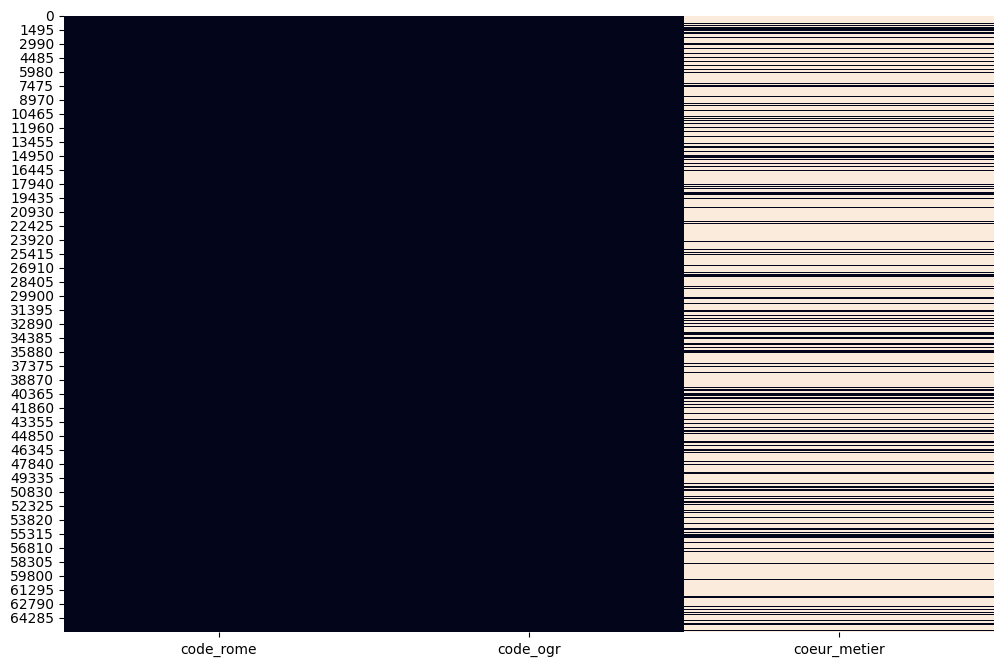

In [29]:
# Identification des valeurs manquantes pour coherence:
# Utilisation de heatmap et isna:
plt.figure(figsize=(12,8))
sns.heatmap(df_cohe.isna(), cbar= False)

In [30]:
# Taux de valeur nulles pour coherence:
(df_cohe.isna().sum()/df_cohe.shape[0]).sort_values(ascending= True)

code_rome       0.000000
code_ogr        0.000000
coeur_metier    0.765423
dtype: float64

In [31]:
# On supprime la colonne inutile:
df_cohe.drop(columns='coeur_metier', axis=0, inplace=True)
df_cohe.shape

(65744, 2)

<Axes: >

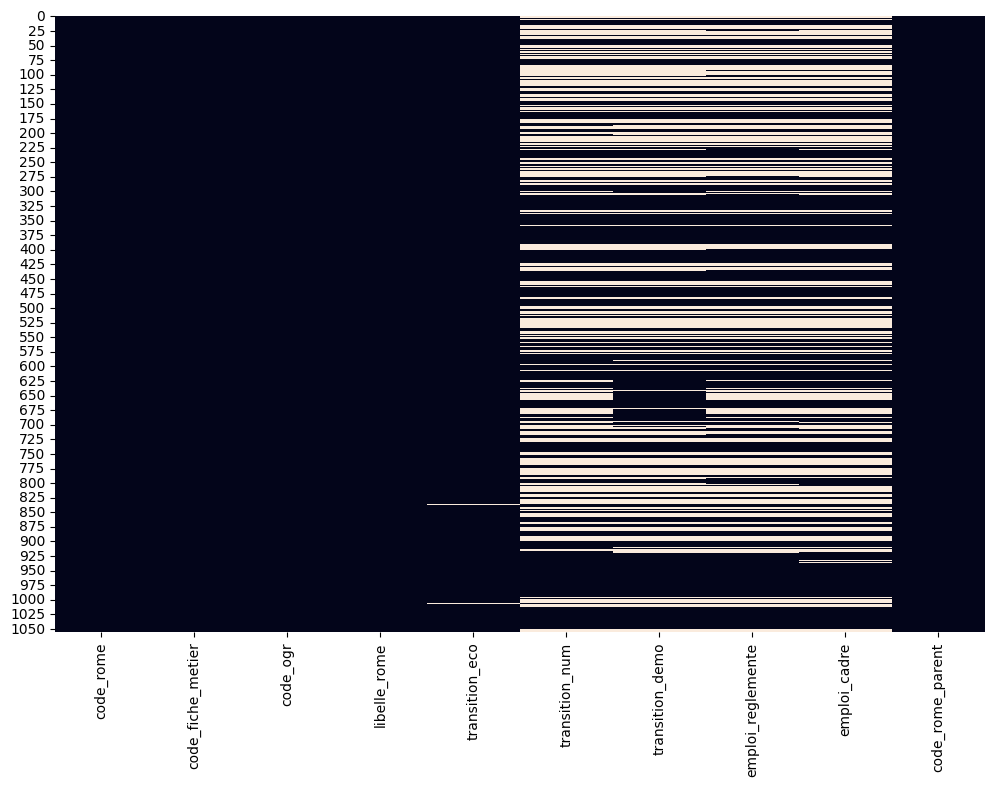

In [32]:
# Identification des valeurs manquantes pour reference:
# Utilisation de heatmap et isna:
plt.figure(figsize=(12,8))
sns.heatmap(df_ref.isna(), cbar= False)

In [33]:
# Suppression des colonnes inutiles (on ne concerve que 3 colonnes):
df_ref = df_ref[['code_rome', 'libelle_rome', 'code_ogr']]
df_ref.shape

(1056, 3)

<Axes: >

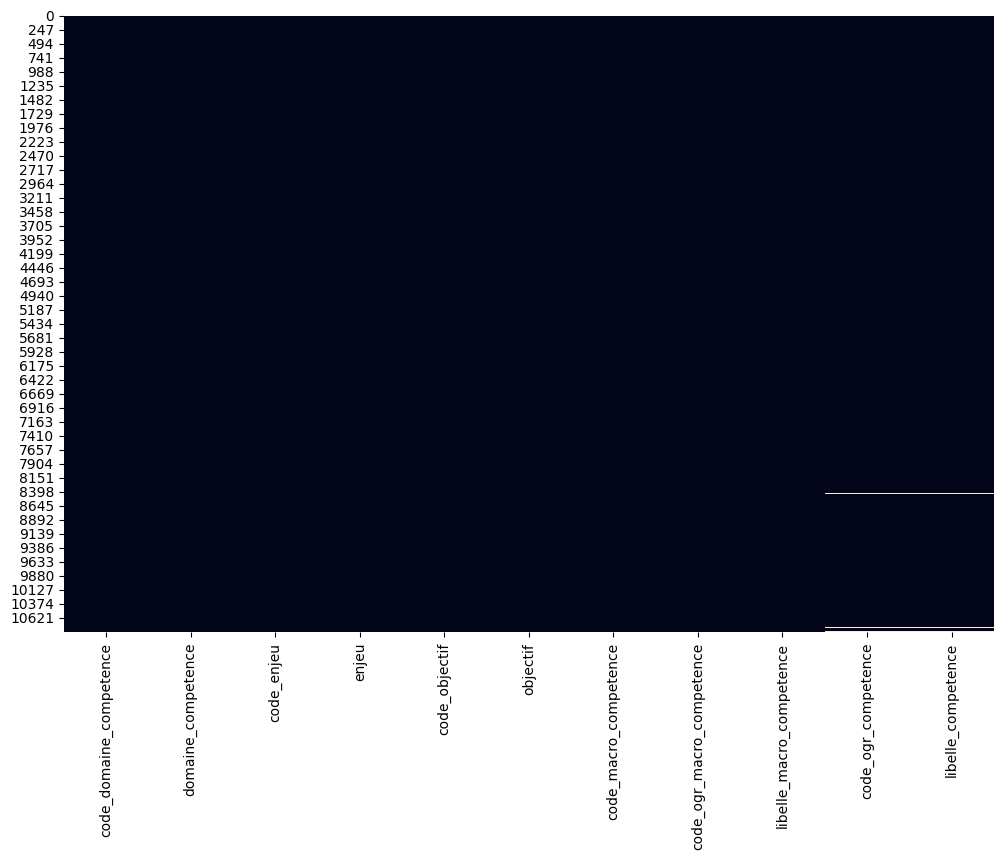

In [34]:
# Identification des valeurs manquantes pour arboresce:
# Utilisation de heatmap et isna:
plt.figure(figsize=(12,8))
sns.heatmap(df_arbo.isna(), cbar= False)

In [35]:
# Nb de valeur nulles pour arborescence:
df_arbo.isna().sum().sort_values(ascending= True)

code_domaine_competence       0
domaine_competence            0
code_enjeu                    0
enjeu                         0
code_objectif                 0
objectif                      0
code_macro_competence         0
code_ogr_macro_competence     0
libelle_macro_competence      0
code_ogr_competence          28
libelle_competence           28
dtype: int64

In [36]:
# Affichage des code OGR competence NULL:
df_arbo[df_arbo['code_ogr_competence'].isna()]

,code_domaine_competence,domaine_competence,code_enjeu,enjeu,code_objectif,objectif,code_macro_competence,code_ogr_macro_competence,libelle_macro_competence,code_ogr_competence,libelle_competence
148,1,"Management, Social, Soin",1B,Management,1B1,Animer un collectif,1B104,300434,"Déléguer, responsabiliser",NaN,NaN
384,1,"Management, Social, Soin",1C,Gestion des Ressources Humaines,1C1,Accompagner le changement,1C102,300002,Organiser des actions de communication interne,NaN,NaN
417,1,"Management, Social, Soin",1C,Gestion des Ressources Humaines,1C2,Gérer les emplois et les compétences,1C204,300005,Procéder au licenciement d'une personne,NaN,NaN
1632,2,"Communication, Création, Innovation, Nouvelles...",2B,Création artistique,2B1,"Composer, mettre en scène",2B103,300094,Orchestrer une oeuvre musicale,NaN,NaN
4173,3,"Production, Construction, Qualité, Logistique",3B,"Production, Fabrication",3B5,"Extraire, exploiter des ressources",3B502,300289,Prospecter en vue d'opérations d'extraction et...,NaN,NaN
8146,4,"Pilotage, Gestion, Cadre réglementaire",4D,"Droit, contentieux et négociation",4D1,Élaborer et appliquer un cadre juridique ou rè...,4D106,300342,Veiller à la sécurité juridique d'une décision...,NaN,NaN
8147,4,"Pilotage, Gestion, Cadre réglementaire",4D,"Droit, contentieux et négociation",4D1,Élaborer et appliquer un cadre juridique ou rè...,4D107,300343,Effectuer une analyse juridique,NaN,NaN
8423,4,"Pilotage, Gestion, Cadre réglementaire",4E,Protection des personnes et de l'environnement,4E2,Protéger l'environnement,4E203,300299,Lutter contre un incendie,NaN,NaN
10787,6,"Coopération, Organisation et Développement de ...",6C,Développement des compétences,6C1,Développer ses compétences,6C101,300491,Mémoriser des informations,NaN,NaN
10818,6,"Coopération, Organisation et Développement de ...",6C,Développement des compétences,6C1,Développer ses compétences,6C104,300496,Identifier ses axes de progrès,NaN,NaN


In [37]:
# Suppression des colonnes inutiles (on ne concerve que 3 colonnes):
df_arbo = df_arbo[['code_macro_competence', 'code_ogr_macro_competence', 'libelle_macro_competence', 'code_ogr_competence', 'libelle_competence']]
df_arbo.shape

(10867, 5)

In [38]:
# Suppression des valeur NULL:
df_arbo = df_arbo.dropna()

# Modification du type 'code_ogr_competence':
df_arbo['code_ogr_competence'] = df_arbo['code_ogr_competence'].astype('int64')

In [39]:
# Visualisation des types de données
df_arbo.dtypes

code_macro_competence        object
code_ogr_macro_competence     int64
libelle_macro_competence     object
code_ogr_competence           int64
libelle_competence           object
dtype: object

# Regroupement des fichiers

In [40]:
#SELECT * FROM rome_coherence_item rci
#  INNER JOIN rome_arborescence_competences rac ON rci.code_ogr = rac.code_ogr_competence ;
# -> 20937 row

#df = df_cohe.join( df_arbo.set_index('code_ogr_competence'), on='code_ogr')
#df.head()

In [41]:
df_merge = pd.merge(df_cohe, df_arbo, left_on='code_ogr', right_on='code_ogr_competence').drop(columns=['code_ogr_competence'])
df_merge.shape

(20937, 6)

In [42]:
df_merge.head(20)

,code_rome,code_ogr,code_macro_competence,code_ogr_macro_competence,libelle_macro_competence,libelle_competence
0,A1101,104016,3F101,300172,"Contrôler le fonctionnement d'un équipement, d...",Contrôler le fonctionnement d'un dispositif de...
1,A1101,107141,3E103,300181,"Entretenir un équipement, une machine, une ins...",Entretenir les mécanismes d'un engin motorisé
2,A1101,110024,3J102,300270,Conduire un véhicule routier,Conduire un poids lourd
3,A1101,117548,3H201,300262,"Trier, ranger des produits, des matières premi...",Stocker un produit
4,A1101,122567,3C104,300297,"Aménager, entretenir un espace naturel, une forêt",Débroussailler une plantation et ses chemins d...
5,A1101,122568,3C104,300297,"Aménager, entretenir un espace naturel, une forêt",Contrôler l'état d'une plantation
6,A1101,122573,3A110,300174,Élaborer et planifier un programme de producti...,"Planifier une opération de semis, de traitemen..."
7,A1101,122730,3C104,300297,"Aménager, entretenir un espace naturel, une forêt","Préparer les sols, les plantations (épandage, ..."
8,A1101,122817,3C104,300297,"Aménager, entretenir un espace naturel, une forêt",Réaliser des travaux d'aménagement
9,A1101,122853,3B401,300294,Cultiver et récolter des végétaux / minéraux,Récolter un produit à maturité et selon les co...


In [43]:
df_merge = pd.merge(df_merge, df_ref, on='code_rome', suffixes=('_coherence', '_reference'))
df_merge.shape

(20937, 8)

In [95]:
# On standardise le nom du DataFrame
df = df_merge.copy()
df.head(20)

,code_rome,code_ogr_coherence,code_macro_competence,code_ogr_macro_competence,libelle_macro_competence,libelle_competence,libelle_rome,code_ogr_reference
0,A1101,104016,3F101,300172,"Contrôler le fonctionnement d'un équipement, d...",Contrôler le fonctionnement d'un dispositif de...,Conducteur / Conductrice d'engins agricoles,6
1,A1101,107141,3E103,300181,"Entretenir un équipement, une machine, une ins...",Entretenir les mécanismes d'un engin motorisé,Conducteur / Conductrice d'engins agricoles,6
2,A1101,110024,3J102,300270,Conduire un véhicule routier,Conduire un poids lourd,Conducteur / Conductrice d'engins agricoles,6
3,A1101,117548,3H201,300262,"Trier, ranger des produits, des matières premi...",Stocker un produit,Conducteur / Conductrice d'engins agricoles,6
4,A1101,122567,3C104,300297,"Aménager, entretenir un espace naturel, une forêt",Débroussailler une plantation et ses chemins d...,Conducteur / Conductrice d'engins agricoles,6
5,A1101,122568,3C104,300297,"Aménager, entretenir un espace naturel, une forêt",Contrôler l'état d'une plantation,Conducteur / Conductrice d'engins agricoles,6
6,A1101,122573,3A110,300174,Élaborer et planifier un programme de producti...,"Planifier une opération de semis, de traitemen...",Conducteur / Conductrice d'engins agricoles,6
7,A1101,122730,3C104,300297,"Aménager, entretenir un espace naturel, une forêt","Préparer les sols, les plantations (épandage, ...",Conducteur / Conductrice d'engins agricoles,6
8,A1101,122817,3C104,300297,"Aménager, entretenir un espace naturel, une forêt",Réaliser des travaux d'aménagement,Conducteur / Conductrice d'engins agricoles,6
9,A1101,122853,3B401,300294,Cultiver et récolter des végétaux / minéraux,Récolter un produit à maturité et selon les co...,Conducteur / Conductrice d'engins agricoles,6


# Examen de la colonne target

In [45]:
df_merge['code_rome'].value_counts()

code_rome
I1610    72
I1619    62
J1510    54
F1201    53
I1611    51
         ..
L1201     4
D1402     4
M1301     3
L1506     2
G1303     2
Name: count, Length: 1056, dtype: int64

In [46]:
df_merge['code_rome'].value_counts(normalize= True)

code_rome
I1610    0.003439
I1619    0.002961
J1510    0.002579
F1201    0.002531
I1611    0.002436
           ...   
L1201    0.000191
D1402    0.000191
M1301    0.000143
L1506    0.000096
G1303    0.000096
Name: proportion, Length: 1056, dtype: float64

# Analyse des variables Quantitatives Continues (Histogramme)

In [68]:
# On standardise le nom du DataFrame pour éviter df/df_merge qui se contredisent
df = df_merge.copy()

import numpy as np, re
import seaborn as sns, matplotlib.pyplot as plt

# Vue d'ensemble
print("Shape:", df.shape)
print(df.dtypes.value_counts(), "\n")

Shape: (20937, 8)
object    5
int64     3
Name: count, dtype: int64 



In [69]:
# On récupère les colonnes numériques (ici, que des int64)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Ces colonnes ressemblent à des codes/IDs → pas d'histogrammes
id_like = [c for c in num_cols if re.search(r"(code|ogr|rome|ref|reference|id|coherence)", c, re.I)]

# Binaires éventuelles (0/1)
binary_cols = [c for c in num_cols if set(df[c].dropna().unique()) <= {0,1}]

# Vraies "continues": numériques avec >10 valeurs distinctes et PAS des codes
cont_cols = [c for c in num_cols 
             if c not in id_like 
             and c not in binary_cols 
             and df[c].nunique(dropna=True) > 10]

print("Numériques:", num_cols)
print("Codes/IDs:", id_like)
print("Binaires:", binary_cols)
print("Continues:", cont_cols)


Numériques: ['code_ogr_coherence', 'code_ogr_macro_competence', 'code_ogr_reference']
Codes/IDs: ['code_ogr_coherence', 'code_ogr_macro_competence', 'code_ogr_reference']
Binaires: []
Continues: []


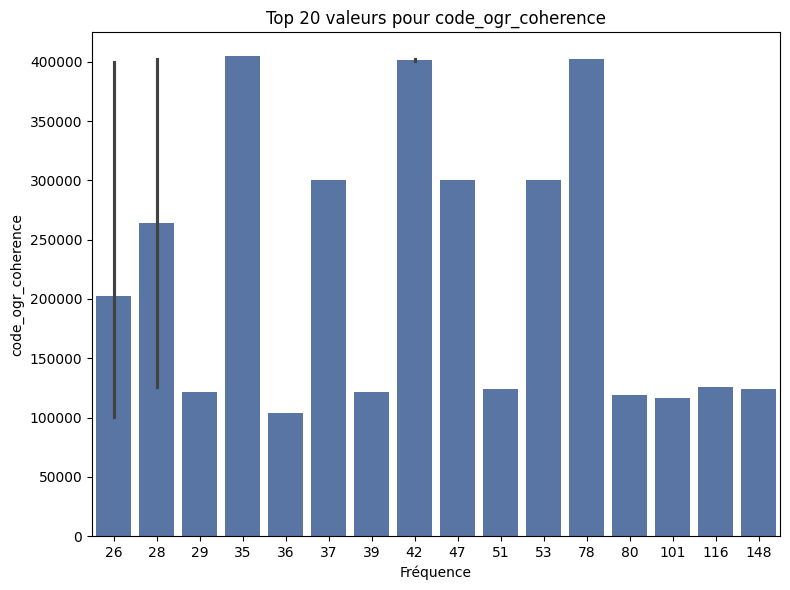

code_ogr_coherence: 20 codes affichés couvrent 5.1% des 20937 lignes



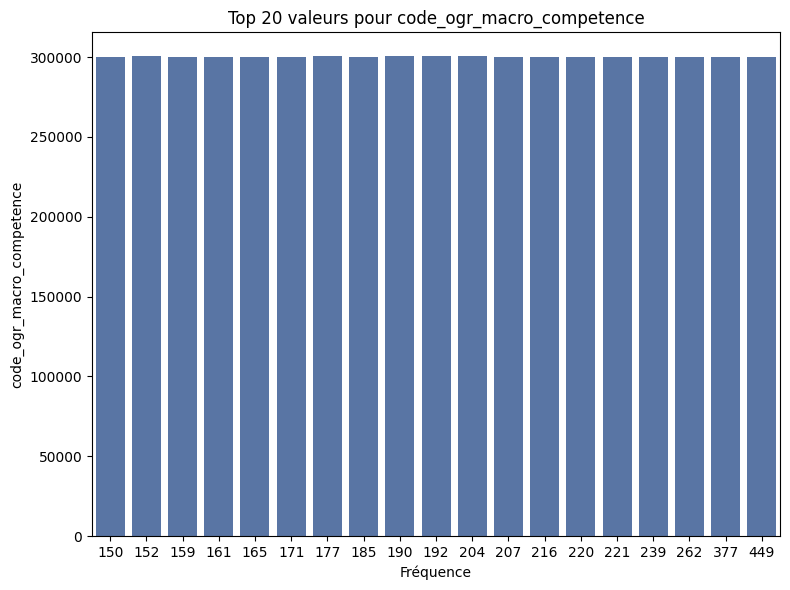

code_ogr_macro_competence: 20 codes affichés couvrent 20.7% des 20937 lignes



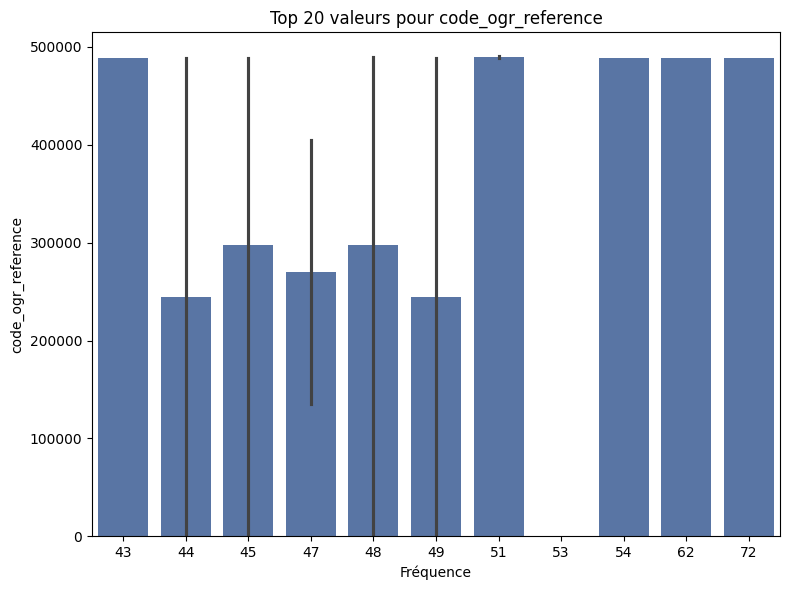

code_ogr_reference: 20 codes affichés couvrent 4.7% des 20937 lignes



In [70]:
# === Objectif ===
# Visualiser les codes les plus fréquents par colonne (catégoriel),
# pour détecter les dominances et le "long tail".

import seaborn as sns
import matplotlib.pyplot as plt

TOPN = 20
for col in id_like:  # défini à l'étape 2
    vc = df[col].value_counts().head(TOPN)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=vc.values, y=vc.index, color="#4C72B0")
    plt.title(f"Top {TOPN} valeurs pour {col}")
    plt.xlabel("Fréquence")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # Petit résumé texte
    total = df.shape[0]
    coverage = vc.sum() / total * 100
    print(f"{col}: {vc.shape[0]} codes affichés couvrent {coverage:.1f}% des {total} lignes\n")

code_ogr_coherence : {'nb_codes_pour_80%': np.int64(5702), 'nb_codes_pour_90%': np.int64(7796), 'nb_codes_pour_95%': np.int64(8843), 'nb_codes_uniques': 9889}


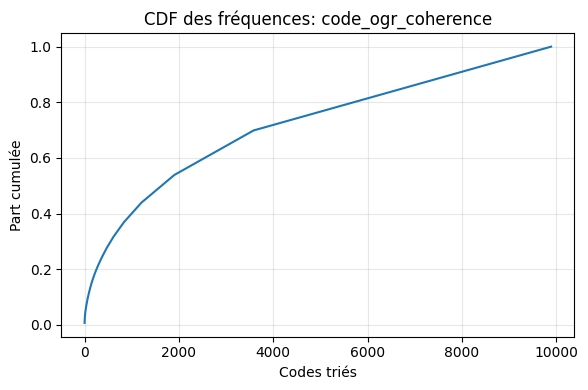

code_ogr_macro_competence : {'nb_codes_pour_80%': np.int64(205), 'nb_codes_pour_90%': np.int64(280), 'nb_codes_pour_95%': np.int64(337), 'nb_codes_uniques': 479}


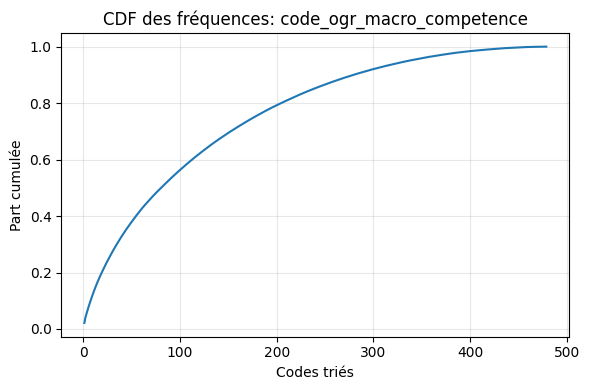

code_ogr_reference : {'nb_codes_pour_80%': np.int64(688), 'nb_codes_pour_90%': np.int64(836), 'nb_codes_pour_95%': np.int64(925), 'nb_codes_uniques': 1056}


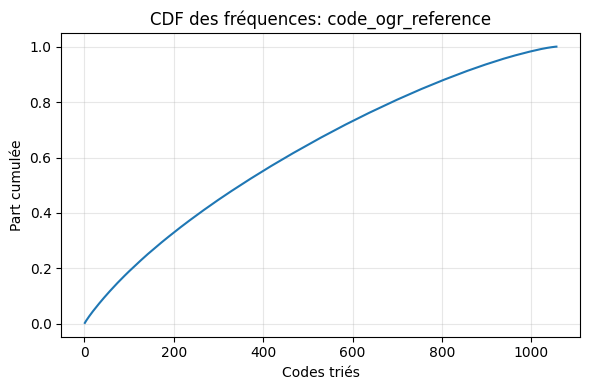

In [ ]:
# === Objectif ===
# Mesurer combien de codes couvrent X% des lignes (80/90/95%),
# pour savoir s'il y a des quelques codes ultra dominants.

import numpy as np
import pandas as pd

def coverage_curve(s: pd.Series, quantiles=(0.8, 0.9, 0.95)):
    vc = s.value_counts()
    cum = vc.cumsum() / vc.sum()
    out = {}
    for q in quantiles:
        k = np.searchsorted(cum.values, q) + 1  # nb de codes pour atteindre q
        out[f"nb_codes_pour_{int(q*100)}%"] = k
    out["nb_codes_uniques"] = vc.shape[0]
    return out, cum

for col in id_like:
    stats, cum = coverage_curve(df[col])
    print(col, ":", stats)
    # tracé rapide de la courbe cumulée
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(cum)+1), cum.values)
    plt.title(f"CDF des fréquences: {col}")
    plt.xlabel("Codes triés")
    plt.ylabel("Part cumulée")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### Analyse des relations métiers - compétences

Dans notre table `df_merge`, chaque ligne correspond déjà à **un couple unique** (un métier associé à une compétence précise).  

Conséquence : si on compte directement les couples `(métier, compétence)`, on obtient toujours `count = 1`.  
Ce n’est pas une erreur, c’est simplement la structure du dataset.

Pour rendre l’analyse informative, il faut **changer le niveau d’agrégation** :  

1. **Nombre de métiers liés à une compétence**  
   - Question : *Cette compétence est-elle rare (spécifique à un métier) ou au contraire transversale (partagée par beaucoup de métiers) ?*  
   - Exemple : “Utiliser un tableur” sera présent dans de nombreux métiers, alors que “Monter un four à pain” sera spécifique.  
   - Méthode : `groupby("compétence")["métier"].nunique()`.  

2. **Nombre de compétences associées à un métier**  
   - Question : *Un métier mobilise-t-il peu ou beaucoup de compétences ?*  
   - Exemple : un métier très spécialisé peut avoir peu de compétences, alors qu’un métier plus transversal en regroupe beaucoup.  
   - Méthode : `groupby("métier")["compétence"].nunique()`.  

3. **Nombre de métiers associés à une macro-compétence**  
   - Question : *Certaines familles de compétences sont-elles présentes dans beaucoup de métiers ?*  
   - Exemple : “Communication” ou “Organisation” sont transversales, alors que “Mécanique de précision” sera limitée à quelques métiers.  
   - Méthode : `groupby("macro_compétence")["métier"].nunique()`.  

---

### Intérêt de cette analyse
- Identifier les **compétences transversales** (présentes dans de nombreux métiers), qui risquent d’être peu discriminantes pour la prédiction.  
- Mettre en évidence les **compétences rares/spécifiques**, utiles pour différencier les métiers.  
- Comparer les **métiers complexes** (beaucoup de compétences nécessaires) aux métiers plus spécialisés.  
- Avoir une vision claire des **déséquilibres** dans le dataset (certaines compétences/métiers dominent, d’autres sont marginaux).  

En résumé, l’analyse ne consiste pas à recompter les couples métier–compétence (toujours uniques), mais à mesurer la **richesse et la transversalité** des relations entre métiers et compétences.


In [88]:
df.groupby("libelle_competence")["libelle_rome"].nunique().sort_values(ascending=False).head(20)

libelle_competence
Assurer la gestion administrative d'une activité                                  148
Définir des besoins en approvisionnement                                          116
Assurer le suivi des stocks en temps réel                                         101
Effectuer la maintenance de premier niveau des outillages et des équipements       80
Favoriser un environnement de travail collaboratif                                 78
Procéder à l'encaissement                                                          53
Réaliser une intervention nécessitant une habilitation                             51
Organiser et planifier une activité                                                47
Intégrer l'éco-responsabilité dans toutes les dimensions de son activité           42
Gérer des situations de crise ou d'urgence                                         42
Sécuriser le périmètre d'intervention                                              39
Communiquer auprès de ses clients i

In [89]:
df.groupby("libelle_rome")["libelle_competence"].nunique().sort_values(ascending=False).head(20)

libelle_rome
Responsable atelier carrosserie                                                           72
Mécanicien / Mécanicienne cycles                                                          62
Infirmier coordinateur / Infirmière coordinatrice (IDEC)                                  54
Conducteur / Conductrice de travaux                                                       53
Préparateur / Préparatrice de véhicules automobiles                                       51
Chef / Cheffe d'équipe travaux publics                                                    51
Mécanicien / Mécanicienne des véhicules des transports routiers                           49
Infirmier / Infirmière en soins généraux (IDE)                                            49
Biostatisticien / Biostatisticienne                                                       48
Mécanicien / Mécanicienne motocycles                                                      48
Chef / Cheffe d'équipe bâtiment                          

In [90]:
df.groupby("libelle_macro_competence")["libelle_rome"].nunique().sort_values(ascending=False).head(20)

libelle_macro_competence
Évaluer, prévenir, et gérer les risques et la sécurité                                292
Gérer les stocks                                                                      242
Définir et mettre en oeuvre des protocoles de sécurité                                206
Assurer la gestion administrative et financière d'une activité                        204
Réaliser une opération de maintenance                                                 183
Rédiger un rapport, un compte rendu d'activité                                        180
Contrôler le fonctionnement d'un équipement, d'une machine, d'une installation        178
Respecter des règles, des consignes, normes et procédures opérationnelles             155
Respecter les règles de Qualité, Hygiène, Sécurité, Santé et Environnement (QHSSE)    155
Entretenir un équipement, une machine, une installation                               154
Mettre en oeuvre les processus et les modes opératoires techniques         

# Analyse des variables Qualitatives

Dans ce dataset, les variables importantes sont toutes **catégorielles** :  
- `libelle_rome` : métiers (cible de notre prédiction)  
- `libelle_competence` : compétences détaillées  
- `libelle_macro_competence` : familles de compétences  

---

### Distribution de la cible (libelle_rome)
Objectif : vérifier combien de métiers différents sont représentés et observer leur fréquence.  
Cela permet de détecter le **déséquilibre de la cible** (certains métiers très fréquents, beaucoup de métiers rares).

### Distribution des compétences (libelle_competence)
Objectif : identifier les compétences les plus fréquentes (transversales) et celles qui apparaissent rarement (spécifiques).

### Distribution des macro-compétences (libelle_macro_competence)
Objectif : observer quelles familles de compétences dominent dans le dataset.

### Relations métiers ↔ compétences
Objectif : comprendre la richesse et la transversalité :
- combien de compétences différentes par métier,  
- combien de métiers différents par compétence,  
- quels liens forts existent entre métiers et macro-compétences.  

---

### Conclusion intermédiaire
- Toutes les variables sont qualitatives, aucun continu.  
- La cible (métiers) est fortement déséquilibrée.  
- Certaines compétences sont très fréquentes (transversales, peu discriminantes), d’autres rares (spécifiques).  
- Ces constats guideront le prétraitement pour le ML :
  - encodage des variables catégorielles,  
  - gestion du déséquilibre de la cible,  
  - métriques adaptées (balanced accuracy, top-k accuracy).

Nombre de métiers différents : 1056


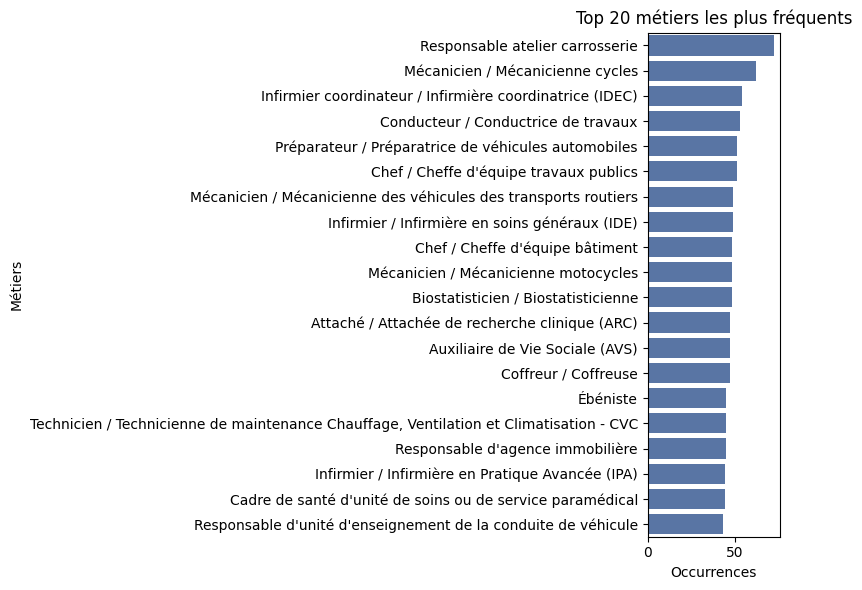

In [96]:
# --- Distribution de la cible (métiers) ---
vc_jobs = df["libelle_rome"].value_counts()
print("Nombre de métiers différents :", vc_jobs.shape[0])
vc_jobs.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=vc_jobs.head(20).values, y=vc_jobs.head(20).index, color="#4C72B0")
plt.title("Top 20 métiers les plus fréquents")
plt.xlabel("Occurrences")
plt.ylabel("Métiers")
plt.tight_layout()
plt.show()

Nombre de compétences différentes : 9889


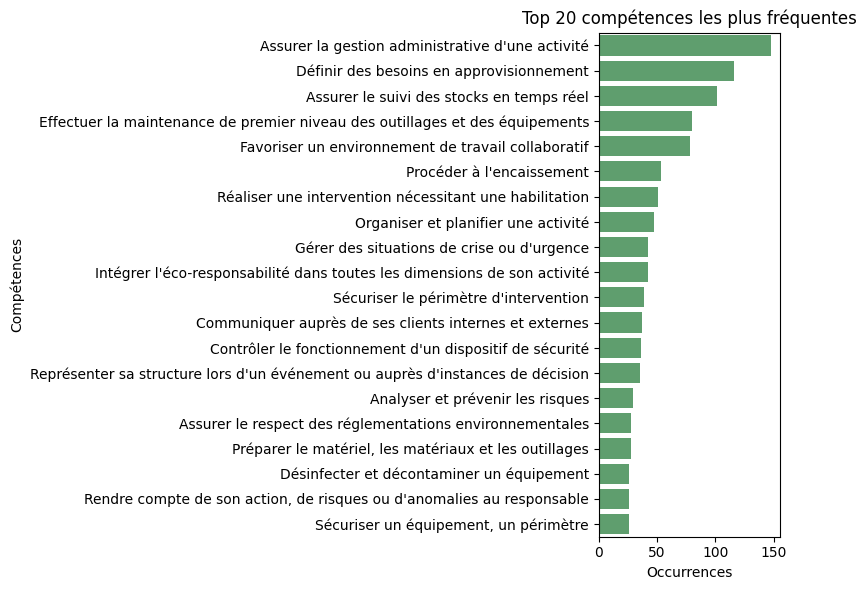

In [97]:
# --- Distribution des compétences ---
vc_comp = df["libelle_competence"].value_counts()
print("Nombre de compétences différentes :", vc_comp.shape[0])
vc_comp.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=vc_comp.head(20).values, y=vc_comp.head(20).index, color="#55A868")
plt.title("Top 20 compétences les plus fréquentes")
plt.xlabel("Occurrences")
plt.ylabel("Compétences")
plt.tight_layout()
plt.show()

Nombre de macro-compétences : 479


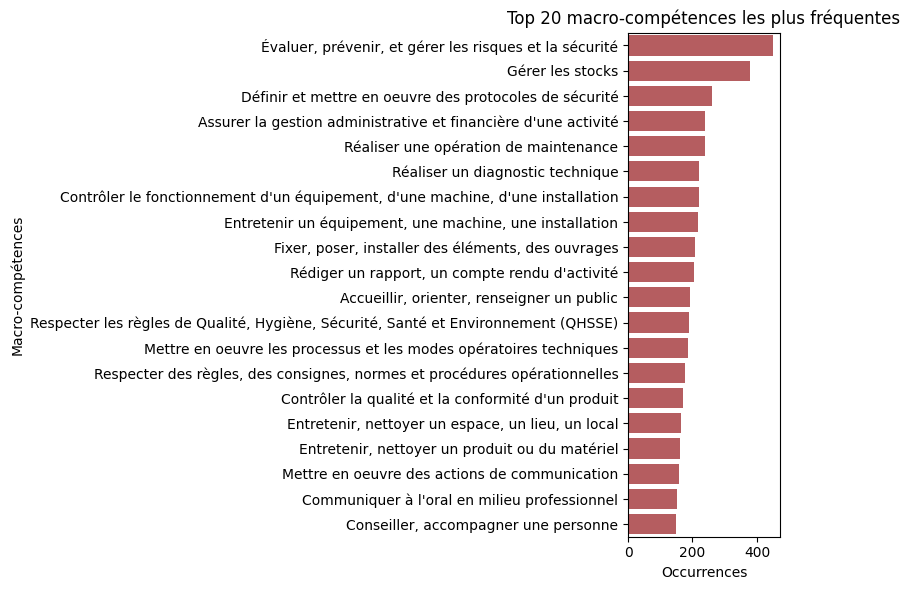

In [101]:
# --- Distribution des macro-compétences ---
vc_macro = df["libelle_macro_competence"].value_counts()
print("Nombre de macro-compétences :", vc_macro.shape[0])

# On garde seulement les 20 plus fréquentes
top_macro = vc_macro.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top_macro.values, y=top_macro.index, color="#C44E52")
plt.title("Top 20 macro-compétences les plus fréquentes")
plt.xlabel("Occurrences")
plt.ylabel("Macro-compétences")
plt.tight_layout()
plt.show()

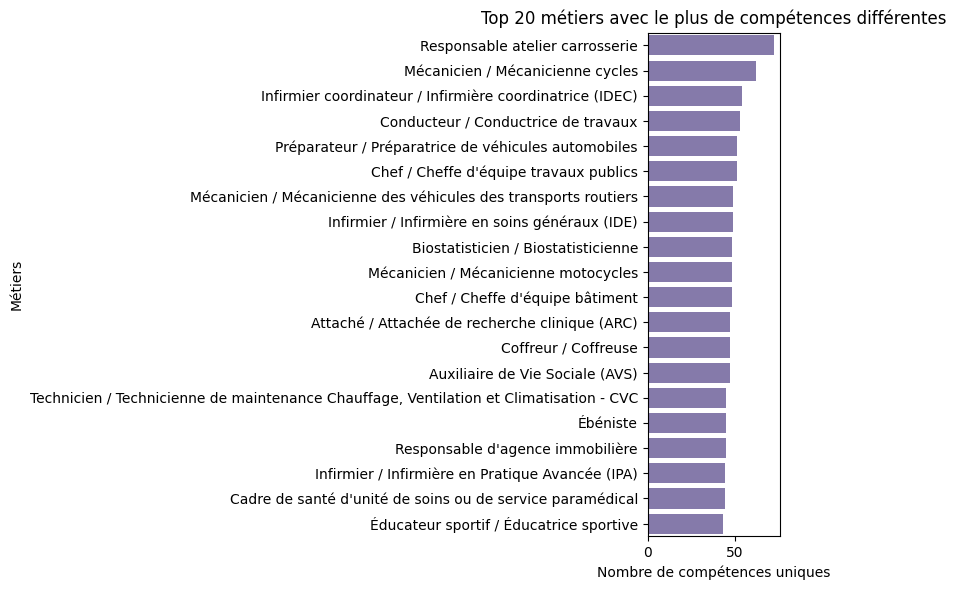

In [99]:
# --- Nb de compétences par métier ---
skills_per_job = df.groupby("libelle_rome")["libelle_competence"].nunique().sort_values(ascending=False)
skills_per_job.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=skills_per_job.head(20).values, y=skills_per_job.head(20).index, color="#8172B2")
plt.title("Top 20 métiers avec le plus de compétences différentes")
plt.xlabel("Nombre de compétences uniques")
plt.ylabel("Métiers")
plt.tight_layout()
plt.show()

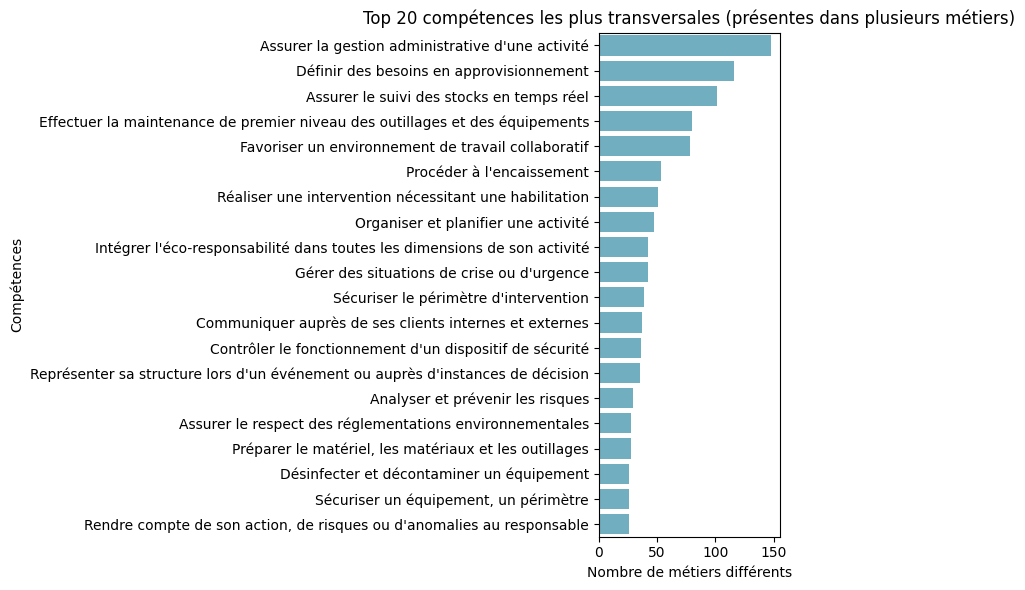

In [100]:
# --- Nb de métiers par compétence ---
jobs_per_skill = df.groupby("libelle_competence")["libelle_rome"].nunique().sort_values(ascending=False)
jobs_per_skill.head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=jobs_per_skill.head(20).values, y=jobs_per_skill.head(20).index, color="#64B5CD")
plt.title("Top 20 compétences les plus transversales (présentes dans plusieurs métiers)")
plt.xlabel("Nombre de métiers différents")
plt.ylabel("Compétences")
plt.tight_layout()
plt.show()

# Conclusion de l’EDA

- Le dataset final contient **20 937 lignes**, avec :
  - **9 889 compétences distinctes** (`libelle_competence`)
  - **479 macro-compétences** (`libelle_macro_competence`)
  - Plusieurs centaines de métiers (`libelle_rome`) à prédire.

- Toutes les variables sont **catégorielles** : pas de variables quantitatives continues.  
  → Les codes OGR sont des identifiants, les libellés sont du texte.  
  → Cela implique un encodage obligatoire (one-hot ou embeddings).

- La cible (`libelle_rome`) est **très déséquilibrée** : quelques métiers concentrent une grande partie des occurrences, tandis que beaucoup sont rares.  
  → C’est un problème de classification **multi-classes déséquilibré**.

- Les compétences suivent une **long tail** : certaines sont très fréquentes et apparaissent dans de nombreux métiers (transversales), d’autres sont rares et n’apparaissent que dans un seul métier (spécifiques).  
  → Les compétences fréquentes risquent d’être peu discriminantes, les compétences rares très discriminantes mais peu représentées.

- Les macro-compétences montrent aussi un déséquilibre : quelques familles dominent, d’autres sont marginales.

---

### Implications pour le ML
- **Encodage** : transformation des compétences/macro-compétences/métiers en vecteurs utilisables par un modèle.  
- **Gestion du déséquilibre** : envisager des stratégies comme le sous-échantillonnage, l’oversampling, l’utilisation de `class_weight` ou l’évaluation avec des métriques adaptées (balanced accuracy, F1-macro, top-k accuracy).  
- **Spécificité vs transversalité** : identifier quelles compétences sont réellement discriminantes pour améliorer la performance des modèles.

En résumé, le dataset est riche mais déséquilibré : la phase de **prétraitement** (encoding + équilibrage) sera cruciale avant d’entraîner un modèle de machine learning.

### Remarque sur l’EDA

Le dataset ROME se compose uniquement de variables **catégorielles** :  
- `libelle_rome` (métiers)  
- `libelle_competence` (compétences)  
- `libelle_macro_competence` (familles de compétences)  

Les colonnes numériques présentes (`code_ogr`, `code_rome`) sont en réalité des **identifiants**, elles ne portent pas d’information quantitative exploitable.

Conséquence :  
- pas d’histogrammes ni de boxplots pertinents,  
- pas de corrélations continues à analyser,  
- l’analyse exploratoire se concentre sur les **fréquences**, les **déséquilibres** et les **relations entre catégories** (métiers ↔ compétences ↔ macro-compétences).

Cela rend l’EDA plus sobre visuellement, mais elle reste adaptée à la nature des données et permet d’identifier les enjeux essentiels pour la suite :  
- déséquilibre fort de la cible,  
- compétences transversales vs compétences spécifiques,  
- richesse variable des métiers en nombre de compétences.